# **Predictive Modeling of Customer Booking**

## **Import Libraries**

In [44]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import uniform
import scipy.stats as stats

# Feature Engineering
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import kendalltau, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer
from imblearn.under_sampling import RandomUnderSampler

# Model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Model Saving
import pickle
import json

import warnings
warnings.filterwarnings('ignore')


## **Data Loading**

In [45]:
# Membuat dataframe dari csv
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [46]:
# Information Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [47]:
# Memeriksa statistika deskriptif pada kolom numerik
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


## **Feature Engineering**

In [48]:
# Mengcopy Dataframe
dfe = df.copy()

### **Check Duplicate**

In [49]:
# Memeriksa data duplikat
dfe.duplicated().sum()

719

In [50]:
# Menghapus data duplikat
dfe.drop_duplicates(inplace=True)

In [51]:
# Information Summary
dfe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  object 
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


### **Splitting Data**

In [52]:
# Split data untuk fitur dan target
X = dfe.drop(columns='booking_complete') #untuk feature
y = dfe['booking_complete'] #untuk target

# Pisahkan inference set terlebih dahulu dari total dataset
X_temp, X_inference, y_temp, y_inference = train_test_split(X,
                                                            y,
                                                            test_size=0.0001,  # Sebagian kecil data untuk inference
                                                            stratify=y,
                                                            random_state=11)

# Split data untuk train set dan test set dari data yang tersisa (X_temp dan y_temp)
X_train, X_test, y_train, y_test = train_test_split(X_temp,
                                                    y_temp,
                                                    test_size=0.1,  # 20% dari data yang tersisa untuk test
                                                    stratify=y_temp,
                                                    random_state=11)

# Cek ukuran dari setiap set
print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test:", X_test.shape)
print("Ukuran X_inference:", X_inference.shape)

Ukuran X_train: (44348, 13)
Ukuran X_test: (4928, 13)
Ukuran X_inference: (5, 13)


### **Handling Missing Value**

In [53]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())
print(X_inference.isnull().sum())

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
dtype: int64
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
dtype: int64
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wa

### **Cardinality Check**

In [54]:
# Fungsi mencari nilai unik
def check_unique_values(data):
    for column in data.columns:
        unique_values = data[column].unique()
        print(f'Kolom: {column}')
        print(f'Jumlah nilai unik: {len(unique_values)}')
        print(f'Nilai unik: {unique_values}\n')

In [55]:
# Menampilkan nilai unik
check_unique_values(X_train)

Kolom: num_passengers
Jumlah nilai unik: 9
Nilai unik: [2 3 1 4 6 5 9 7 8]

Kolom: sales_channel
Jumlah nilai unik: 2
Nilai unik: ['Internet' 'Mobile']

Kolom: trip_type
Jumlah nilai unik: 3
Nilai unik: ['RoundTrip' 'OneWay' 'CircleTrip']

Kolom: purchase_lead
Jumlah nilai unik: 467
Nilai unik: [ 15  17  30   4 124  98  90 385   2  74  75  35 114  99  96 133  88   7
 105   0  42  23   8 102  12   3  64   9 184 180  40 296  45  77 108  79
 122  36 338  33  34  29  83  97  37  91  26 218 229 298  27 125 288  54
  73 205  66 129  85  56  58  55  44  13  24  16  50  47  10  25  59  67
 109  20 251  49  11 415 113  39  31  32 139   5  19 169  81  28 412 278
 159 367  68   6 316  41  84  61  63 279 224  65  18 119 127  71  14  51
 103  86  93 234 137 112  60 161  62 195 182  48 331  57  46  72 424  38
 176 164 204 157 368 107 100  69 132  21 179 246  76  80   1 258  43 199
 111 216 403 401 170  87  94 286  82  52 210 386  53 323  95 168 285 135
 130 178 228 217 158  22 136 183 245 402 302 41

### **Handling Outlier**

In [56]:
# Memilih kolom numerik
cols = ['purchase_lead', 'length_of_stay', 'flight_duration']

In [57]:
# Memeriksa outlier dari gambar

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

Generating plots for: purchase_lead


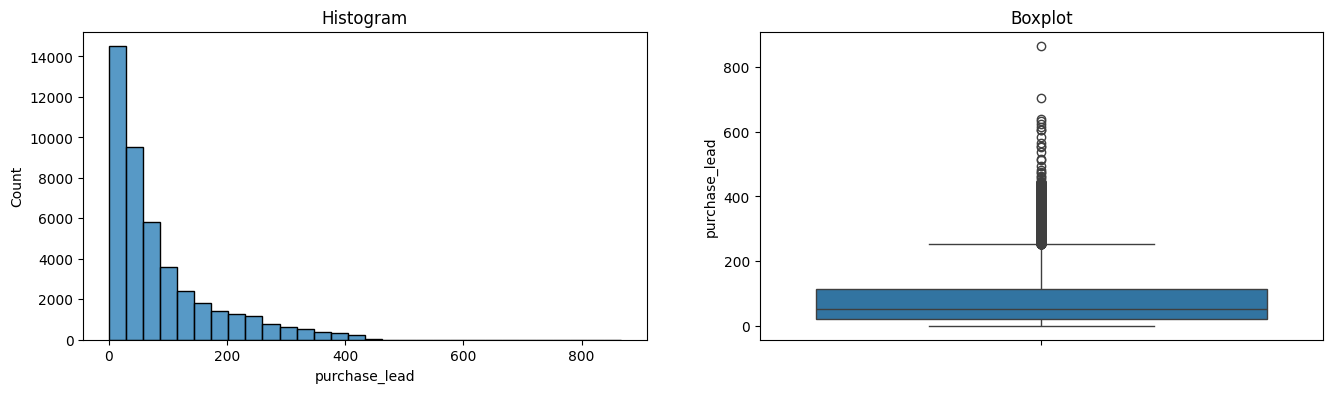

Generating plots for: length_of_stay


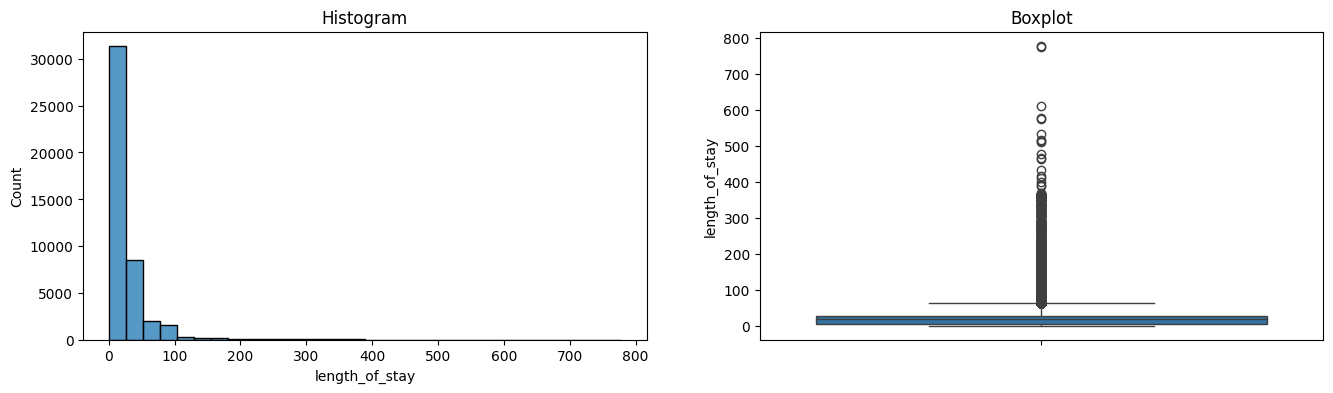

Generating plots for: flight_duration


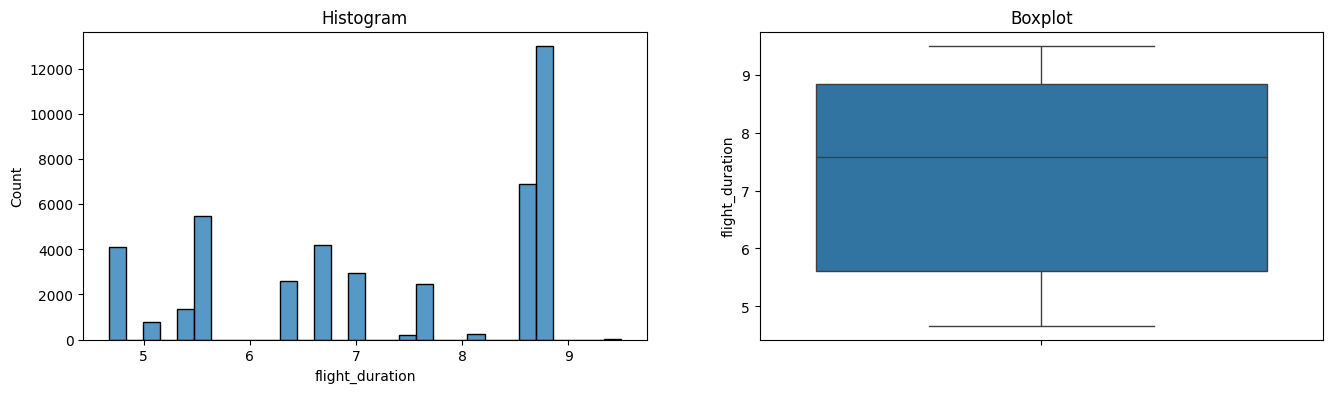

In [58]:
columns_to_plot = cols  # Tentukan kolom yang ingin di-plot

# Memanggil fungsi untuk kolom yang ditentukan
for column in columns_to_plot:
    # Periksa apakah kolom ada dalam DataFrame
    if column in X_train.columns:
        # Periksa apakah kolom bertipe numerik atau boolean
        if pd.api.types.is_numeric_dtype(X_train[column]) or pd.api.types.is_bool_dtype(X_train[column]):
            print(f'Generating plots for: {column}')
            diagnostic_plots(X_train, column)
        else:
            print(f'Kolom {column} bukan tipe numerik atau boolean. Skipping.')
    else:
        print(f'Kolom {column} tidak ditemukan dalam DataFrame.')

In [59]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,44348.0,1.590624,1.012836,1.00,1.00,1.00,2.00,9.0
purchase_lead,44348.0,84.467349,90.247886,0.00,21.00,51.00,114.00,867.0
length_of_stay,44348.0,23.122869,33.809178,0.00,5.00,17.00,28.00,778.0
flight_hour,44348.0,9.055019,5.420039,0.00,5.00,9.00,13.00,23.0
wants_extra_baggage,44348.0,0.669636,0.470350,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,44348.0,0.295977,0.456486,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,44348.0,0.427077,0.494659,0.00,0.00,0.00,1.00,1.0
flight_duration,44348.0,7.285372,1.496657,4.67,5.62,7.57,8.83,9.5


In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44348 entries, 43761 to 33446
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         44348 non-null  int64  
 1   sales_channel          44348 non-null  object 
 2   trip_type              44348 non-null  object 
 3   purchase_lead          44348 non-null  int64  
 4   length_of_stay         44348 non-null  int64  
 5   flight_hour            44348 non-null  int64  
 6   flight_day             44348 non-null  object 
 7   route                  44348 non-null  object 
 8   booking_origin         44348 non-null  object 
 9   wants_extra_baggage    44348 non-null  int64  
 10  wants_preferred_seat   44348 non-null  int64  
 11  wants_in_flight_meals  44348 non-null  int64  
 12  flight_duration        44348 non-null  float64
dtypes: float64(1), int64(7), object(5)
memory usage: 4.7+ MB


In [61]:
def check_outlier(df, num_cols):
    # List untuk menyimpan hasil dari setiap kolom
    results = []

    for column in num_cols:
        # Hitung skewness
        skewness = stats.skew(df[column])

        # Tentukan tingkat skewness
        if skewness <= 0.5 and skewness >= -0.5 :
            skewness_level = "Normal"
            capping_method = "Gaussian"
        elif skewness <= 1 and skewness >= -1:
            skewness_level = "Medium Skew"
            capping_method = "IQR/Percentile"
        else:
            skewness_level = "High Skew"
            capping_method = "IQR/Percentile"

        # Cari outlier menggunakan z-score jika data normal, Tukey jika data skew
        if skewness <= 0.5:
            # Menggunakan z-score untuk data yang mendekati normal
            outliers = np.abs(stats.zscore(df[column])) > 3
        else:
            # Menggunakan IQR (metode Tukey) untuk data yang skewed
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = (df[column] < lower_bound) | (df[column] > upper_bound)

         # Hitung jumlah outliers
        num_outliers = outliers.sum()

        # Ambil nilai outliers
        outliers_values = df[column][outliers].tolist()

        # Simpan hasil dalam list
        results.append({
            "Nama Kolom": column,
            "Nilai Skewness": skewness,
            "Tingkat Skewness": skewness_level,
            # "Metode capping" : capping_method,
            # "Batas Bawah" : lower_bound,
            # "Batas Atas" : upper_bound,
            "Banyak Outliers": num_outliers,
            "Nilai Outliers": outliers_values
        })


    # Buat dataframe dari hasil
    results_df = pd.DataFrame(results)
    return results_df


In [62]:
# periksa outlier
check_outlier(X_train, cols)

,Nama Kolom,Nilai Skewness,Tingkat Skewness,Banyak Outliers,Nilai Outliers
0,purchase_lead,1.661716,High Skew,3152,"[385, 296, 338, 298, 288, 415, 412, 278, 367, ..."
1,length_of_stay,5.266738,High Skew,3393,"[80, 91, 478, 88, 84, 74, 90, 89, 65, 65, 76, ..."
2,flight_duration,-0.367296,Normal,0,[]


In [63]:
def skewness_check_outlier_handling_train(df, column):
    """
    Fungsi untuk mengecek skewness, mencari outlier, dan handling outlier pada kolom tertentu pada data latih (fit dan transform)

    Parameters:
    df (pandas DataFrame): Dataframe yang berisi data latih
    column (str): Nama kolom yang ingin dianalisis

    Returns:
    tuple: (Dataframe yang telah di-handle outlier, Objek Winsorizer yang di-fit)
    """
    # Hitung skewness
    skewness = stats.skew(df[column])
    print(f"Skewness: {skewness}")

    # Cari outlier menggunakan z-score jika data normal, Tukey jika data skew
    if skewness < 0.5:
        outliers = np.abs(stats.zscore(df[column])) > 3
    else:
        q1, q3 = np.percentile(df[column], [25, 75])
        iqr = q3 - q1
        outliers = (df[column] < q1 - 1.5 * iqr) | (df[column] > q3 + 1.5 * iqr)

    # Tampilkan outlier
    if np.any(outliers):
        num_outliers = outliers.sum()
        print(f"Outliers detected: {num_outliers} ({df[column][outliers]})")
    else:
        print("No outliers detected")

    # Klasifikasi skewness dan menentukan metode winsorization
    if skewness < 0.5 and skewness >= -0.5 :
        print("Data terdistribusi normal")
        winsorizer = Winsorizer(capping_method='gaussian',
                               tail='both',
                               fold=3,
                               variables=[column])
                               # missing_values='ignore')
    elif skewness < 1 and skewness >= -1:
        print("Data memiliki skew")
        winsorizer = Winsorizer(capping_method='iqr',
                               tail='both',
                               fold=1.5,
                               variables=[column])
                               # missing_values='ignore')
    else:
        print("Data memiliki skew esktrim")
        winsorizer = Winsorizer(capping_method='quantiles',
                               tail='both',
                               fold=0.1,
                               variables=[column])
                               # missing_values='ignore')

    # Fit dan transform pada data latih
    df[[column]] = winsorizer.fit_transform(df[[column]])

    return df, winsorizer

In [64]:
# Daftar kolom numerik kecuali 'day' dan 'pdays'
num_cols_outlier = [col for col in cols if col not in ['flight_duration']]

# Daftar kolom yang ingin di-handle outlier
columns_to_handle = num_cols_outlier

# Loop untuk setiap kolom
for column in columns_to_handle:
    print(f"Handling outlier pada kolom {column} : ")
    # dfe_capped = skewness_check_outlier_handling(dfe, column)
    dfe_c, winsorizer = skewness_check_outlier_handling_train(X_train, column)
    print("Outlier handling selesai pada kolom {}\n".format(column))

print("Outlier handling sudah selesai di semua kolom!")


Handling outlier pada kolom purchase_lead : 
Skewness: 1.6617164897970613
Outliers detected: 3152 (43150    385
24952    296
34899    338
1385     298
24606    288
        ... 
49304    258
42159    256
33280    263
26023    271
48743    275
Name: purchase_lead, Length: 3152, dtype: int64)
Data memiliki skew esktrim


Outlier handling selesai pada kolom purchase_lead

Handling outlier pada kolom length_of_stay : 
Skewness: 5.2667380227105
Outliers detected: 3393 (18620     80
20821     91
19734    478
1385      88
24606     84
        ... 
2253      84
17136     71
12703     72
25464    180
2059     156
Name: length_of_stay, Length: 3393, dtype: int64)
Data memiliki skew esktrim
Outlier handling selesai pada kolom length_of_stay

Outlier handling sudah selesai di semua kolom!


In [65]:
# periksa outlier
check_outlier(X_train, cols)

,Nama Kolom,Nilai Skewness,Tingkat Skewness,Banyak Outliers,Nilai Outliers
0,purchase_lead,0.984332,Medium Skew,0,[]
1,length_of_stay,0.897825,Medium Skew,0,[]
2,flight_duration,-0.367296,Normal,0,[]


Generating plots for: purchase_lead


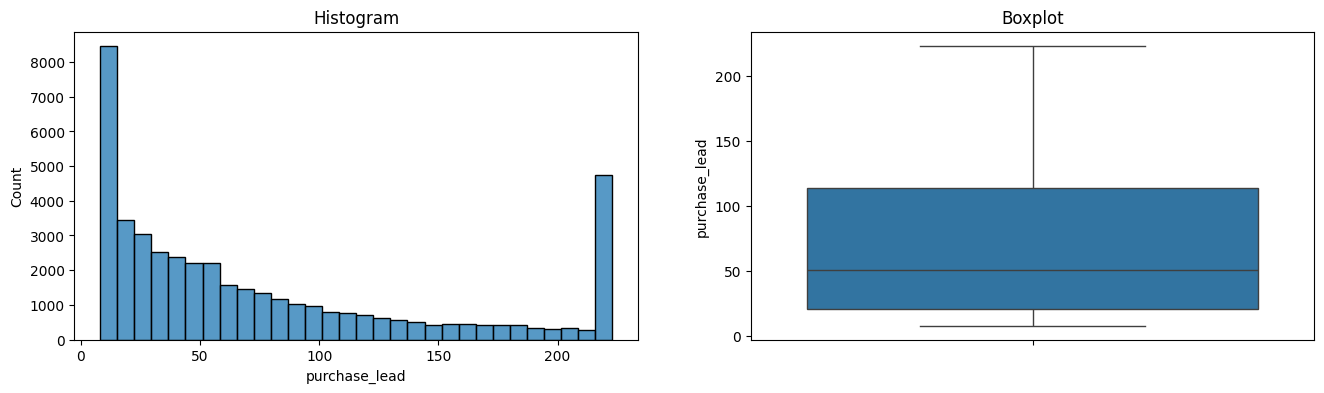

Generating plots for: length_of_stay


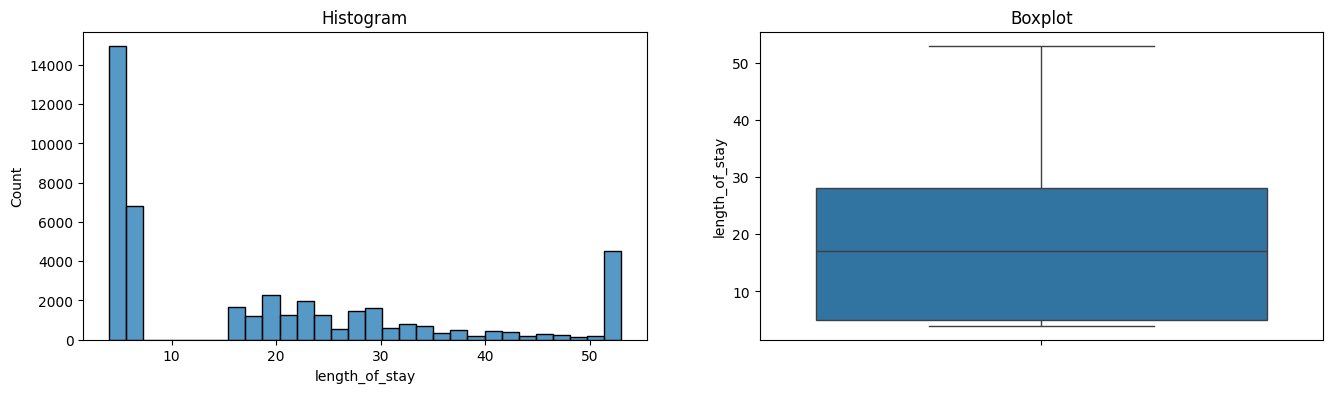

Generating plots for: flight_duration


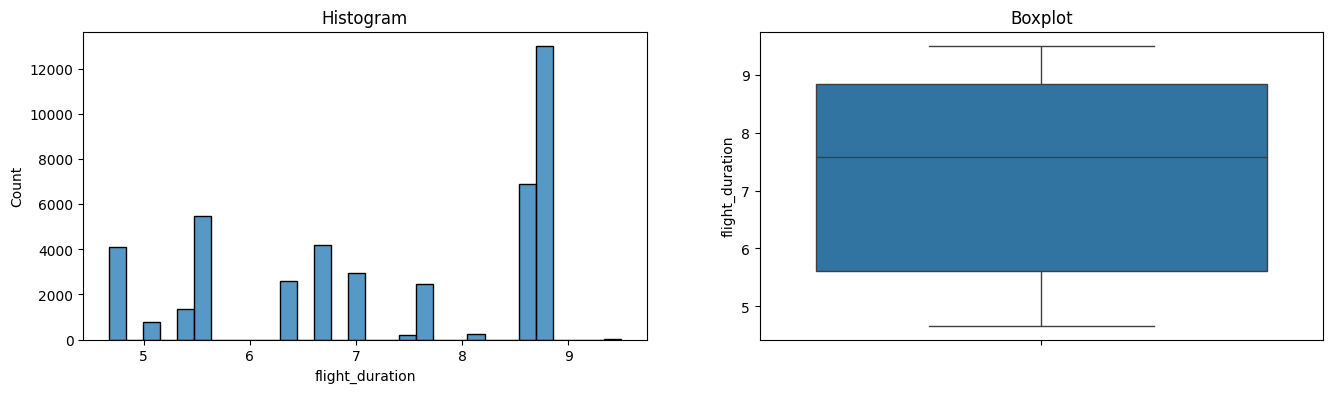

In [66]:
columns_to_plot = cols  # Tentukan kolom yang ingin di-plot

# Memanggil fungsi untuk kolom yang ditentukan
for column in columns_to_plot:
    # Periksa apakah kolom ada dalam DataFrame
    if column in X_train.columns:
        # Periksa apakah kolom bertipe numerik atau boolean
        if pd.api.types.is_numeric_dtype(X_train[column]) or pd.api.types.is_bool_dtype(X_train[column]):
            print(f'Generating plots for: {column}')
            diagnostic_plots(X_train, column)
        else:
            print(f'Kolom {column} bukan tipe numerik atau boolean. Skipping.')
    else:
        print(f'Kolom {column} tidak ditemukan dalam DataFrame.')

### **Feature Selection**

In [67]:
cat_cols = ['num_passengers', 'sales_channel', 'trip_type', 'flight_hour', 
            'flight_day', 'route', 'booking_origin', 'wants_extra_baggage',
             'wants_preferred_seat', 'wants_in_flight_meals' ]
num_cols = ['purchase_lead', 'length_of_stay', 'flight_duration']

In [68]:
### Uji Kendall's Tau
for col in X_train[num_cols]:
    # if X_train[col].dtype == 'object':  
    #     X_train[col] = X_train[col].astype('category').cat.codes
    
    tau, p_value = stats.kendalltau(X_train[col], y_train)
    print(f"Korelasi Kendall Tau antara kolom {col} dan y_train:")
    print(f"Tau: {tau}, P-value: {p_value}\n")

### Uji Chi-Square 
for col in X_train[cat_cols]:
    # if X_train[col].dtype == 'object':  
        contingency_table = pd.crosstab(X_train[col], y_train)
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        print(f"Chi-Square Test antara kolom {col} dan y_train:")
        print(f"Chi2 Statistic: {chi2}, P-value: {p}\n")
        # print(f"Expected Frequencies: \n{expected}\n")

Korelasi Kendall Tau antara kolom purchase_lead dan y_train:
Tau: -0.0277874137318563, P-value: 1.471136775116823e-12

Korelasi Kendall Tau antara kolom length_of_stay dan y_train:
Tau: -0.07392418305029926, P-value: 2.9037876752844696e-74

Korelasi Kendall Tau antara kolom flight_duration dan y_train:
Tau: -0.08529919105395571, P-value: 2.833200209581178e-95

Chi-Square Test antara kolom num_passengers dan y_train:
Chi2 Statistic: 42.80254311444144, P-value: 9.56925267735654e-07

Chi-Square Test antara kolom sales_channel dan y_train:
Chi2 Statistic: 74.77681235537247, P-value: 5.270510441582697e-18

Chi-Square Test antara kolom trip_type dan y_train:
Chi2 Statistic: 40.145970057121964, P-value: 1.916078804471791e-09

Chi-Square Test antara kolom flight_hour dan y_train:
Chi2 Statistic: 130.75470476868395, P-value: 4.656091247389742e-17

Chi-Square Test antara kolom flight_day dan y_train:
Chi2 Statistic: 10.013700715158029, P-value: 0.12407623711993966

Chi-Square Test antara kolom r

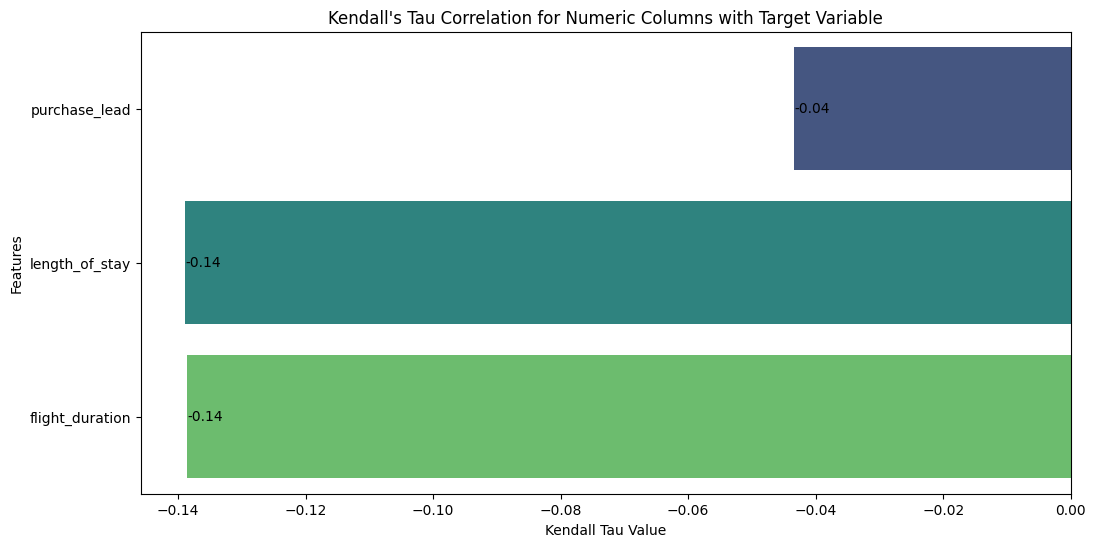

<module 'matplotlib.pyplot' from 'c:\\Users\\Dimasmo\\miniconda3\\envs\\phase1\\lib\\site-packages\\matplotlib\\pyplot.py'>

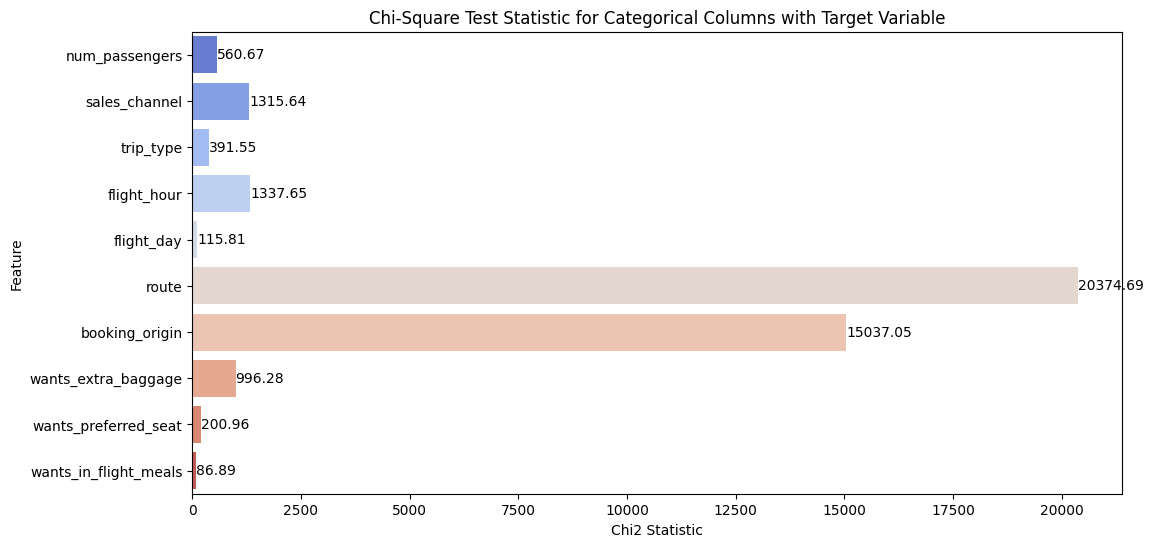

In [114]:
# --- 1. Visualisasi Kendall's Tau untuk Fitur Numerik ---
kendall_results = []
for col in X_train[num_cols]:
    tau, _ = stats.kendalltau(X_train[col], y_train)
    kendall_results.append({
        'Feature': col,
        'Kendall Tau': tau
    })

# Membuat DataFrame untuk hasil Kendall's Tau
kendall_df = pd.DataFrame(kendall_results)

# Plot bar chart untuk Kendall's Tau
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Kendall Tau', y='Feature', data=kendall_df, palette='viridis')

# Menambahkan nilai Kendall Tau di atas setiap batang
for index, value in enumerate(kendall_df['Kendall Tau']):
    ax.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")

plt.title("Kendall's Tau Correlation for Numeric Columns with Target Variable")
plt.xlabel("Kendall Tau Value")
plt.ylabel("Features")
plt.show()

# --- 2. Visualisasi Chi-Square untuk Fitur Kategorikal ---
chi2_results = []
for col in X_train[cat_cols]:
    contingency_table = pd.crosstab(X_train[col], y_train)
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)
    chi2_results.append({
        'Feature': col,
        'Chi2 Statistic': chi2
    })

# Membuat DataFrame untuk hasil Chi-Square
chi2_df = pd.DataFrame(chi2_results)

# Plot bar chart untuk Chi-Square Statistic
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Chi2 Statistic', y='Feature', data=chi2_df, palette='coolwarm')

# Menambahkan nilai Chi-Square Statistic di atas setiap batang
for index, value in enumerate(chi2_df['Chi2 Statistic']):
    ax.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")

plt.title("Chi-Square Test Statistic for Categorical Columns with Target Variable")
plt.xlabel("Chi2 Statistic")
plt


### **Mutual Information**

In [69]:
X= X_train.copy()
y= y_train.copy()       

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [70]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [71]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.052873
booking_origin           0.047199
flight_duration          0.016256
wants_extra_baggage      0.010599
length_of_stay           0.006081
wants_in_flight_meals    0.004968
wants_preferred_seat     0.003484
num_passengers           0.002962
flight_day               0.001995
flight_hour              0.001393
purchase_lead            0.000922
sales_channel            0.000000
trip_type                0.000000
Name: MI Scores, dtype: float64

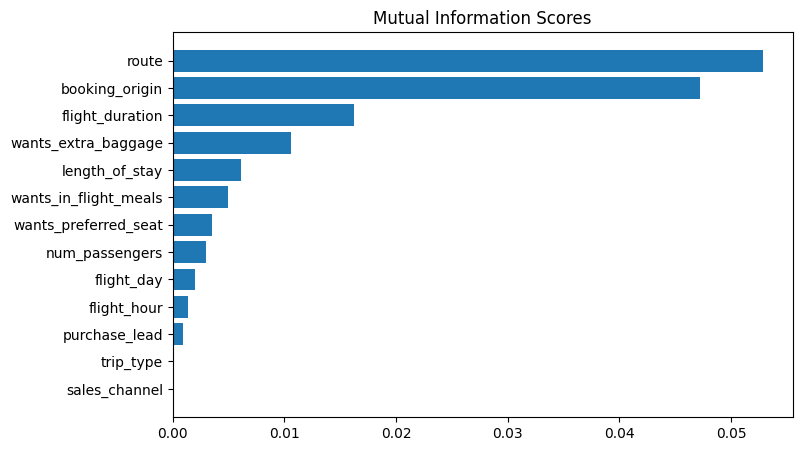

In [72]:

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### **VIF**

In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [80]:
vif = calculate_vif(X)
vif

,Features,VIF
0,num_passengers,3.581285
1,sales_channel,1.128093
2,trip_type,1.012963
3,purchase_lead,2.356459
4,length_of_stay,2.672949
5,flight_hour,3.571090
6,flight_day,2.991627
7,route,1.955734
8,booking_origin,1.690325
9,wants_extra_baggage,3.487596


### **Data Balancing**

In [73]:
y_train.value_counts()

booking_complete
0    37697
1     6651
Name: count, dtype: int64

In [74]:
X_train

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
43761,2,Internet,RoundTrip,15,6,21,Thu,COKSYD,India,1,1,1,8.58
18620,3,Internet,RoundTrip,17,53,0,Wed,MELMNL,Australia,1,1,1,8.83
5914,1,Internet,RoundTrip,30,32,13,Thu,COKHGH,China,0,0,1,5.07
48918,1,Internet,RoundTrip,8,6,16,Wed,MELPNH,Cambodia,1,0,0,8.83
2756,2,Internet,RoundTrip,124,31,9,Fri,BLRMEL,Australia,1,1,1,8.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7863,2,Mobile,RoundTrip,184,26,8,Fri,DACSYD,Australia,1,1,1,8.58
29630,4,Internet,RoundTrip,83,4,8,Sat,BKIPUS,South Korea,0,0,1,6.33
41834,8,Mobile,RoundTrip,223,5,3,Sat,PERSIN,Australia,1,0,0,5.62
14438,1,Internet,RoundTrip,38,35,12,Thu,ICNSYD,South Korea,1,0,0,8.58


In [75]:
# # Implementasi Random Under Sampler 
# rus = RandomUnderSampler(random_state=42)
# X_train_resample, y_train_resample = rus.fit_resample(X_train, y_train)

In [76]:
# Implementasi SMOTENC
from imblearn.over_sampling import SMOTENC
smotenc = SMOTENC([0,1,2,5,6,7,8,9,10,11],random_state=42)
X_train,y_train = smotenc.fit_resample(X_train,y_train)
y_train.value_counts()

booking_complete
1    37697
0    37697
Name: count, dtype: int64

## **Model Definition**

In [81]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE

# ColumnTransformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        # ('ordinal', OrdinalEncoder(categories=[]), categorical_ordinal_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Pipeline untuk preprocessing dan model Logistic Regression
pipeline_ranfor = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=11))
])

In [82]:
pipeline_ranfor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['purchase_lead',
                                                   'length_of_stay',
                                                   'flight_duration']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['num_passengers',
                                                   'sales_channel', 'trip_type',
                                                   'flight_hour', 'flight_day',
                                                   'route', 'booking_origin',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flight_meals'])])),
                ('classifier', RandomForestClassifier(random_state=11))])

In [83]:
from sklearn.metrics import classification_report, precision_score, make_scorer, roc_auc_score

# Melatih model train
pipeline_ranfor.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor.predict(X_train)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor.predict_proba(X_train)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_train, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_train, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor, X_train, y_train, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())


Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37697
           1       1.00      1.00      1.00     37697

    accuracy                           1.00     75394
   macro avg       1.00      1.00      1.00     75394
weighted avg       1.00      1.00      1.00     75394

ROC AUC Score: 0.9999665173374351
Cross-Validation Precision Scores :  [0.86720029 0.8765209  0.88333738 0.87941034 0.88418627]
Mean Precision Score :  0.8781310366308613
Standar Deviasi Precision Score :  0.006123433736871307


In [84]:
from sklearn.metrics import roc_auc_score

# Melatih model train
pipeline_ranfor.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor.predict(X_test)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_test, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor, X_test, y_test, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())


Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4189
           1       0.35      0.37      0.36       739

    accuracy                           0.80      4928
   macro avg       0.62      0.62      0.62      4928
weighted avg       0.81      0.80      0.80      4928

ROC AUC Score: 0.7469639054020922
Cross-Validation Precision Scores :  [0.69230769 0.5        0.7        0.52941176 0.375     ]
Mean Precision Score :  0.5593438914027149
Standar Deviasi Precision Score :  0.12317776844036274


In [86]:
cat_cols1 = ['num_passengers', 'trip_type', 'flight_hour', 
            'flight_day', 'booking_origin', 'wants_extra_baggage',
             'wants_preferred_seat', 'wants_in_flight_meals' ]
num_cols1 = ['purchase_lead', 'length_of_stay', 'flight_duration']

In [88]:
# ColumnTransformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols1),
        # ('ordinal', OrdinalEncoder(categories=[]), categorical_ordinal_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols1)
    ])

# Pipeline untuk preprocessing dan model Logistic Regression
pipeline_ranfor1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=11))
])

In [89]:
# Melatih model train
pipeline_ranfor1.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor1.predict(X_train)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor1.predict_proba(X_train)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_train, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_train, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor1, X_train, y_train, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())


Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37697
           1       1.00      1.00      1.00     37697

    accuracy                           1.00     75394
   macro avg       1.00      1.00      1.00     75394
weighted avg       1.00      1.00      1.00     75394

ROC AUC Score: 0.9999149116322333
Cross-Validation Precision Scores :  [0.83864302 0.86123481 0.86790154 0.86508804 0.86078858]
Mean Precision Score :  0.8587311958975841
Standar Deviasi Precision Score :  0.010378250439385048


In [90]:
# Melatih model train
pipeline_ranfor1.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor1.predict(X_test)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor1.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_test, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor1, X_test, y_test, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())


Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4189
           1       0.30      0.35      0.33       739

    accuracy                           0.78      4928
   macro avg       0.59      0.60      0.60      4928
weighted avg       0.80      0.78      0.79      4928

ROC AUC Score: 0.7114958275604869
Cross-Validation Precision Scores :  [0.44444444 0.61538462 0.5625     0.35714286 0.66666667]
Mean Precision Score :  0.5292277167277167
Standar Deviasi Precision Score :  0.11333218707679446


In [91]:
cat_cols2 = ['num_passengers', 'sales_channel', 'trip_type', 'flight_hour', 
            'flight_day', 'booking_origin']
num_cols2 = ['purchase_lead', 'length_of_stay', 'flight_duration']

In [92]:
# ColumnTransformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols2),
        # ('ordinal', OrdinalEncoder(categories=[]), categorical_ordinal_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols2)
    ])

# Pipeline untuk preprocessing dan model Logistic Regression
pipeline_ranfor2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=11))
])

In [93]:
# Melatih model train
pipeline_ranfor2.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor2.predict(X_train)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor2.predict_proba(X_train)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_train, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_train, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor2, X_train, y_train, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())


Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     37697
           1       0.99      1.00      1.00     37697

    accuracy                           1.00     75394
   macro avg       1.00      1.00      1.00     75394
weighted avg       1.00      1.00      1.00     75394

ROC AUC Score: 0.9997280378984023
Cross-Validation Precision Scores :  [0.81666367 0.84201099 0.84915049 0.84432301 0.84387066]
Mean Precision Score :  0.8392037627278501
Standar Deviasi Precision Score :  0.011513991539944418


In [94]:
# Melatih model train
pipeline_ranfor2.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor2.predict(X_test)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor2.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_test, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor2, X_test, y_test, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())

Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4189
           1       0.28      0.35      0.31       739

    accuracy                           0.77      4928
   macro avg       0.58      0.60      0.59      4928
weighted avg       0.79      0.77      0.78      4928

ROC AUC Score: 0.695631900159933
Cross-Validation Precision Scores :  [0.33333333 0.33333333 0.3        0.28       0.4       ]
Mean Precision Score :  0.3293333333333333
Standar Deviasi Precision Score :  0.04079215610874228


In [95]:
cat_cols3 = ['num_passengers', 'sales_channel', 'trip_type', 'flight_hour', 
            'flight_day', 'route', 'booking_origin', 'wants_extra_baggage',
             'wants_preferred_seat', 'wants_in_flight_meals' ]
num_cols3 = ['purchase_lead', 'length_of_stay']

In [96]:
# ColumnTransformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols2),
        # ('ordinal', OrdinalEncoder(categories=[]), categorical_ordinal_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols2)
    ])

# Pipeline untuk preprocessing dan model Logistic Regression
pipeline_ranfor3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=11))
])

In [97]:
# Melatih model train
pipeline_ranfor3.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor3.predict(X_train)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor3.predict_proba(X_train)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_train, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_train, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor3, X_train, y_train, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())


Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     37697
           1       0.99      1.00      1.00     37697

    accuracy                           1.00     75394
   macro avg       1.00      1.00      1.00     75394
weighted avg       1.00      1.00      1.00     75394

ROC AUC Score: 0.9997280378984023
Cross-Validation Precision Scores :  [0.81666367 0.84201099 0.84915049 0.84432301 0.84387066]
Mean Precision Score :  0.8392037627278501
Standar Deviasi Precision Score :  0.011513991539944418


In [98]:
# Melatih model train
pipeline_ranfor3.fit(X_train, y_train)

# Prediksi pada data uji 
y_pred_ranfor = pipeline_ranfor3.predict(X_test)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_ranfor = pipeline_ranfor3.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report 
print("Classification Report :")
print(classification_report(y_test, y_pred_ranfor))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_ranfor)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_ranfor = cross_val_score(pipeline_ranfor3, X_test, y_test, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_ranfor)
print("Mean Precision Score : ", cv_scores_ranfor.mean())
print("Standar Deviasi Precision Score : ", cv_scores_ranfor.std())

Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4189
           1       0.28      0.35      0.31       739

    accuracy                           0.77      4928
   macro avg       0.58      0.60      0.59      4928
weighted avg       0.79      0.77      0.78      4928

ROC AUC Score: 0.695631900159933
Cross-Validation Precision Scores :  [0.33333333 0.33333333 0.3        0.28       0.4       ]
Mean Precision Score :  0.3293333333333333
Standar Deviasi Precision Score :  0.04079215610874228


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Setup Randomized Search
random_search = RandomizedSearchCV(pipeline_ranfor, param_distributions=param_grid, n_iter=100, 
                                    cv=5, scoring='precision', random_state=42, n_jobs=-1)

# Fit Randomized Search
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Print best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None}


In [ ]:
# Best parameters found:  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None}

In [103]:
# Prediksi pada data train dengan model terbaik
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_train)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_best = best_model.predict_proba(X_train)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report untuk model terbaik
print("Classification Report (Best Model):")
print(classification_report(y_train, y_pred_best))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_train, y_pred_prob_best)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_best = cross_val_score(best_model, X_train, y_train, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_best)
print("Mean Precision Score : ", cv_scores_best.mean())
print("Standar Deviasi Precision Score : ", cv_scores_best.std())


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37697
           1       1.00      1.00      1.00     37697

    accuracy                           1.00     75394
   macro avg       1.00      1.00      1.00     75394
weighted avg       1.00      1.00      1.00     75394

ROC AUC Score: 0.9999136154202066
Cross-Validation Precision Scores :  [0.83703955 0.85958323 0.86241898 0.86126675 0.85900085]
Mean Precision Score :  0.8558618726044754
Standar Deviasi Precision Score :  0.00948883339643051


In [104]:
# Prediksi pada data test dengan model terbaik
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Prediksi probabilitas untuk ROC AUC
y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

# Classification Report untuk model terbaik
print("Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_best)
print("ROC AUC Score:", roc_auc)

# Tentukan custom scorer untuk precision dengan label 'yes' sebagai positif
precision_scorer = make_scorer(precision_score)

# Cross-Validation Score 
cv_scores_best = cross_val_score(best_model, X_test, y_test, cv=5, scoring=precision_scorer)
print("Cross-Validation Precision Scores : ", cv_scores_best)
print("Mean Precision Score : ", cv_scores_best.mean())
print("Standar Deviasi Precision Score : ", cv_scores_best.std())


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4189
           1       0.30      0.35      0.32       739

    accuracy                           0.78      4928
   macro avg       0.59      0.60      0.60      4928
weighted avg       0.80      0.78      0.79      4928

ROC AUC Score: 0.7053564477620523
Cross-Validation Precision Scores :  [0.5625     0.75       0.66666667 0.38888889 0.77777778]
Mean Precision Score :  0.6291666666666667
Standar Deviasi Precision Score :  0.14161218996145428


## **Model Saving**

In [ ]:
# Menyimpan pipeline dengan pickle
with open('pipeline_ranfor.pkl', 'wb') as file_1:
    pickle.dump(pipeline_ranfor, file_1)



In [106]:
# Menyimpan tuning model
with open('best_model.pkl', 'wb') as file_2:
    pickle.dump(best_model, file_2)